# TABLE OF CONTENTS: 


* [Data Import & Cleaning](#data_load_and_clean)
* [Data Preparation & Dummy Variable Creation](#exog_var)
* [Breakpoint Subsampling Split for Training/Test Sets](#sub_sampling)
* [Initial Data Exploration: ACF / PACF](#initial_data_exploration)
* [Forecasting Overview](#forecasting_intro)
    * [Naive Mean (Baseline)](#naive_forecast)
    * [Walk-Forward SARIMAX](#sarimax)
    * [Static SARIMAX Forecast](#static_sarimax)
    * [TBATS](#tbats)
    * [XGBoost](#xgboost)
        * [Feature Engineering](#feature_engineering)
        * [XGBoost Parameter Tuning](#xgboost_param_tuning)
        * [XGBoost Output Explanation using SHAP (SHapley Additive exPlanations)](#xgboost_shap) 
    * [Final Results: Model Comparisons & Conclusion](#final_results)

### BUSINESS PROBLEM 
* Because purchase budgets are contingent on the sales forecast (calculated as COGS benchmarks) at the end of each month for the proceding month, the sales forecasts are running 4w static forecasts. This means that the next month's sales (forecasted by week) must be forecasted in advance and cannot be iteratively updated; some exceptions exist in extreme circumstances, such as extreme weather events for instance.


#### INTRO ... 
* ... 

In [ ]:
# 13.04.21
- add long term XGBOOST model? 
- finish results comparison section and gralph
- consider: an example of OOS forecasting 
- consider: adding hybrid SARIMAX / TBATS model in long-term models? 


# 08.04.21
- move on to using SVM (titantic kaggle) for customer email prediction (binary classification outcome)
- how to if__==main_- to initialise or run intra-notebook? 

## compare to TBATS class: & write all to class + add class method for MSE comparison 
https://github.com/intive-DataScience/tbats
    
# include graphs for mean / std_dev etc. 
- https://github.com/Vaibhavs10/ml-with-timeseries/blob/master/stochastic-models.ipynb
    
# exgboost param guide: 
- http://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [1]:
## import packages ## 
import warnings
import sys
if not sys.warnoptions:
    warnings.filterwarnings("ignore")  

In [2]:
## date working / printing packages
import datetime
from datetime import date, timedelta, datetime
from tabulate import tabulate

# core packages
import numpy as np 
import pandas as pd
#import collections 

## graphing packages ## 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from statsmodels.tsa.stattools import zivot_andrews
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# import a common error for the sarimax models 
from numpy.linalg import LinAlgError

# add all sklearn here or remove 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from arch.unitroot import DFGLS

#from statsmodels.tools.sm_exceptions import ValueWarning

In [4]:
## optional packages / display preferences ##
pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)

from IPython.display import display
pd.options.display.max_columns = 60  
plt.style.use('seaborn')

## may require pip install 
from see import see   

In [25]:
#pip install pmdarima
#from tbats import TBATS
#import pmdarima as pm


# remove this or add XGBOOSt to here? 

In [19]:
#daily_data_date_df.to_pickle("./daily_data_date_df.pkl")
daily_data_date_df = pd.read_pickle("./daily_data_date_df.pkl") 

#extended_date_df = pd.read_pickle("./extended_date_df.pkl") 

In [6]:
daily_postpb_train = pd.read_pickle("./daily_postpb_train.pkl") 
daily_postb_test = pd.read_pickle("./daily_postb_test.pkl") 

#daily_postpb_train_60d = pd.read_pickle("./daily_postpb_train_60d.pkl") 
#daily_postb_test_60d = pd.read_pickle("./daily_postb_test_60d.pkl") 

In [10]:
#extended_date_df = pd.read_pickle("./extended_date_df.pkl") 


# LINKS / QUERIES
* https://towardsdatascience.com/garch-processes-monte-carlo-simulations-for-analytical-forecast-27edf77b2787
* https://www.w3schools.com/python/ref_set_intersection.asp
* https://machinelearningmastery.com/make-sample-forecasts-arima-python/



## Queries:
* When was mermaid refurb started / finished? 


## package links
* https://pypi.org/project/holidays/

In [12]:
n = 1000

def sum_numpy(n=1000):
    return np.sum(np.arange(n))
## note arange = (0, n-1) range


In [ ]:
def mean_forecast_error(series, series_yhat):
    return series.sub(series_yhat).mean()

<a id='data_load_and_clean'></a>

## LOAD THE DATA FROM EXCEL (XLSX) FILE
* Data includes at a store-level, on a daily basis: 
    * Sales / GP / Promo Sales 
    * Baskets (# of transactions) and average basket 
    * Recorded Waste / Markdowns / Cost adjustments (internal stock adjustments E.G. theft, IT errors etc.)
    * number of items sold / number of items sold at normal price / number sold on a promo price
    * Loyalty Sales (purchases made by someone using a loyalty card)
    * GST 

In [21]:
# import xlsx file
daily_data_df = pd.read_excel(r'daily_aggsales_baskets_promoqty_gst.xlsx')

In [23]:
# === NOTE === # 
# to protect the anonymity of the data, the actual store_name has been replaced with a code word
# this store name has been hidden below, replaced by the string "####"
daily_data_df['Store'] = daily_data_df['Store'].replace("####", "MW")

In [25]:
## the final day of data must be incompletely loaded from the data-source as it's only 1/3 of a usual day; remove it
daily_data_df = daily_data_df[:-1]

# display head
daily_data_df.head()

,Store,Sales $,GP $,Promo Sales $,Promo Sales %,Baskets,Avg Basket $,Waste$,Markdown$,Items,Normal Qty,Promo Qty,Loyalty Sales $,Cost Adjustment$,GST $,DATEALTERNATEKEY
0,MW,"23,935.00","5,185.96","10,006.91",0.42,1251,19.13,78.27,138.66,4822,"2,912.33","1,703.68",563.81,688.07,"1,204.91",2019-01-01
1,MW,"23,143.62","5,040.71","8,577.01",0.37,1249,18.53,631.34,52.22,4593,"2,900.68","1,361.61",455.57,"-1,957.71","1,178.69",2019-01-02
2,MW,"25,507.01","4,930.69","8,092.75",0.32,1319,19.34,136.37,92.87,4416,"2,822.38","1,325.85",405.81,57.36,"1,145.91",2019-01-03
3,MW,"25,124.87","5,199.56","11,219.92",0.45,1276,19.69,54.79,101.97,4721,"2,806.18","1,704.90",732.95,"1,636.20","1,352.07",2019-01-04
4,MW,"25,241.23","5,437.24","10,073.29",0.40,1328,19.01,66.59,58.32,4844,"2,866.64","1,698.61",284.96,-155.23,"1,295.07",2019-01-05


## DATA COLUMN NAMES CLEANING & REINDEXING DF
* clean up the messy column names: remove the symbols / punctuation marks / whitespace and make it all lower case

In [ ]:
# import regex for this step; then it is no longer needed 
import regex as re

In [21]:
# loop over the DF's column names and replace
for i, val in enumerate(daily_data_df.columns.values):
    daily_data_df.columns.values[i] = re.sub('[^A-Za-z0-9]+', '', val.lower())

In [29]:
# [optional] make a copy of it, to specify a separate named DF that indicates the date as index 
daily_data_date_df = daily_data_df.copy()

# set date column as index
daily_data_date_df = daily_data_date_df.set_index('datealternatekey')

In [29]:
# E.G. cleaned column names & datetime index
daily_data_date_df.head(2)

,store,sales,gp,promosales,promosales,baskets,avgbasket,waste,markdown,items,normalqty,promoqty,loyaltysales,costadjustment,gst,publichol
datealternatekey,,,,,,,,,,,,,,,,
2019-01-01,MW,"23,935.00","5,185.96","10,006.91",0.42,1251,19.13,78.27,138.66,4822,"2,912.33","1,703.68",563.81,688.07,"1,204.91",1
2019-01-02,MW,"23,143.62","5,040.71","8,577.01",0.37,1249,18.53,631.34,52.22,4593,"2,900.68","1,361.61",455.57,"-1,957.71","1,178.69",0


<a id='exog_var'></a>

## DETECT PUBLIC-HOLIDAYS & CREATE A DUMMY VARIABLE INDICATOR
* For example, mark particularly busy days such as Labour Day, so feed into the time series models as an exogenous variable later

In [ ]:
# import special library for holidays: / may require pip install 
import holidays

In [12]:
# initalise an instance of Australia-Queensland specific regional holidays
aus_qld_holidays = holidays.CountryHoliday('AUS', prov='QLD')

In [13]:
## append some custom holidays or holiday phenomena unique this retail business
# E.G. The day before mothers day is busy, mothers day itself is not so much > etc. 
aus_qld_holidays.append({"2019-05-11": "Mothers Day Eve",
                         "2019-12-23": "Pre Xmas Eve",
                         "2029-12-24": "Christmas Eve",
                        "2020-12-24" : "Christmas Eve",
                        "2020-12-23" : "Pre Xmas Eve",
                        "2020-05-09" : "Mothers Day Eve",
                        "2021-05-08" : "Mothers Day Eve",
                        "2021-12-23" : "Pre Xmas Eve",
                        "2021-12-24" : "Christmas Eve"})

In [15]:
# print out a visualisation of each holiday per year in the sample period 
unique_holidays = []

for i in daily_data_date_df.index: #daily_data_date_df['datealternatekey']:
    if aus_qld_holidays.get(i) is not None:
        unique_hol = str(aus_qld_holidays.get(i)) + ", " + str(i.year)
        unique_holidays.append(unique_hol)

In [16]:
# E.G. of holidays present in sample
unique_holidays

["New Year's Day, 2019",
 'Australia Day, 2019',
 'Australia Day (Observed), 2019',
 'Good Friday, 2019',
 'Easter Saturday, 2019',
 'Easter Sunday, 2019',
 'Easter Monday, 2019',
 'Anzac Day, 2019',
 'Labour Day, 2019',
 'Mothers Day Eve, 2019',
 'The Royal Queensland Show, 2019',
 "Queen's Birthday, 2019",
 'Pre Xmas Eve, 2019',
 'Christmas Day, 2019',
 'Boxing Day, 2019',
 "New Year's Day, 2020",
 'Australia Day, 2020',
 'Australia Day (Observed), 2020',
 'Good Friday, 2020',
 'Easter Saturday, 2020',
 'Easter Sunday, 2020',
 'Easter Monday, 2020',
 'Anzac Day, 2020',
 'Labour Day, 2020',
 'Mothers Day Eve, 2020',
 'The Royal Queensland Show, 2020',
 "Queen's Birthday, 2020",
 'Pre Xmas Eve, 2020',
 'Christmas Eve, 2020',
 'Christmas Day, 2020',
 'Boxing Day, 2020',
 'Boxing Day (Observed), 2020',
 "New Year's Day, 2021",
 'Australia Day, 2021']

## INITIALISE A DUMMY-VARIABLE TO MARK PUBLIC HOLIDAYS


In [17]:
# set a row's "public_hol" value to (1) if that day was a holiday, otherwise set it (0)
daily_data_date_df['publichol'] = [int(1) if aus_qld_holidays.get(i) is not None else int(0) for i in daily_data_date_df.index] 

In [ ]:
# optional: March 17th 2020; COVID lockdown announcement - could manually insert an additional holiday marker for this event
#daily_postbp_df.loc['2020-03-17', 'publichol'] = 1

## CREATE OUT-OF-SAMPLE (OOS) DATE + HOLIDAY DUMMY-VARIABLE
* Extend the most recent in-sample date by 365 days (which is longer than the forecast will actually be, but this just gives flexibility to adjust forecasts lengths at will in subsequent steps)

In [22]:
# reset the index to make the datetime index offsets easier 
daily_data_date_df_reset = daily_data_date_df.reset_index()

In [23]:
## define an extended series for inputting future dummy variables in the forecasts

#start_date = pd.DatetimeIndex(daily_data_df['datealternatekey'][:1])

start_date = pd.DatetimeIndex(daily_data_date_df_reset['datealternatekey']).max() + pd.DateOffset(1)
end_date = pd.DatetimeIndex(daily_data_date_df_reset['datealternatekey'][-1:] + pd.DateOffset(365))

extended_date = pd.date_range(start_date, end_date.max())
## now start/end of series is 2021-03-24 to 2022-03-23

In [24]:
# convert series to DF to make it easier to pass into the subsequent time series models as an exog with matching indexes
extended_date_df = pd.DataFrame(data=(extended_date), columns=['date'])

In [25]:
# apply the same dummy-variable principle as above
extended_date_df['publichol_x'] = [int(1) if aus_qld_holidays.get(i) is not None else int(0) for i in extended_date] 

# set date as the index
extended_date_df = extended_date_df.set_index('date')

In [26]:
# pickle DF object (optional)
extended_date_df.to_pickle("./extended_date_df.pkl")

## FINAL DF INFO CHECK
* Check there are no NaN / Missing Values etc. before loading the models

In [39]:
daily_data_date_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 813 entries, 2019-01-01 to 2021-03-23
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   store           813 non-null    object 
 1   sales           813 non-null    float64
 2   gp              813 non-null    float64
 3   promosales      813 non-null    float64
 4   promosales      813 non-null    float64
 5   baskets         813 non-null    int64  
 6   avgbasket       813 non-null    float64
 7   waste           807 non-null    float64
 8   markdown        813 non-null    float64
 9   items           813 non-null    int64  
 10  normalqty       813 non-null    float64
 11  promoqty        813 non-null    float64
 12  loyaltysales    813 non-null    float64
 13  costadjustment  811 non-null    float64
 14  gst             813 non-null    float64
 15  publichol       813 non-null    int64  
dtypes: float64(12), int64(3), object(1)
memory usage: 108.0+ KB


In [ ]:
# No NaNs; data looks good thus far. Else, most reasonable course is to drop Nan(s) depending on volume

<a id='sub_sampling'></a>

## SELECTING THE RIGHT TRAINING / TEST SPLIT SUB-SAMPLE
* Issues arise over a regime shift which occured around the time of covid, let's see if we can analytically pin point this time
* We know QLD state formerly announced a lockdown around March 20, 2020. 

In [20]:
# calculate the breakpoint 
zivot_andrews_bp_sales = zivot_andrews(daily_data_date_df.sales,
                                            trim=0.2, maxlag=7, regression='c', autolag='t-stat')

In [21]:
# create a string version of the index location of the breakpoint (indexed by the 4th object in the ZA return dict)
date_location_za = str(daily_data_date_df.index[zivot_andrews_bp_sales[4]])

# for visual appeal, strip back the timestamp elements (00:00:00) as the smallest frequency of the data is daily
date_location_za_strp = datetime.strptime(date_location_za, '%Y-%m-%d %H:%M:%S')
            
date_location_za_clean = date_location_za_strp.strftime('%Y-%m-%d')

# if test_stat is < CV (more negative) reject null hypothesis = there is statistically significant breakpoint 
print("calculated breakpoint date is: {} with corresponding test statistic: {} vs. 5% CV of: {}".format(
date_location_za_clean, np.round(zivot_andrews_bp_sales[0], 2), zivot_andrews_bp_sales[2]['5%']))

calculated breakpoint date is: 2020-03-13 with corresponding test statistic: -6.89 vs. 5% CV of: -4.81067


In [22]:
## split the DF and use the data post-BP
# variable: date_location_za_clean   is from the ZivotAndrews BP calculation above 
daily_postbp_df = daily_data_date_df[daily_data_date_df.index > date_location_za_clean]

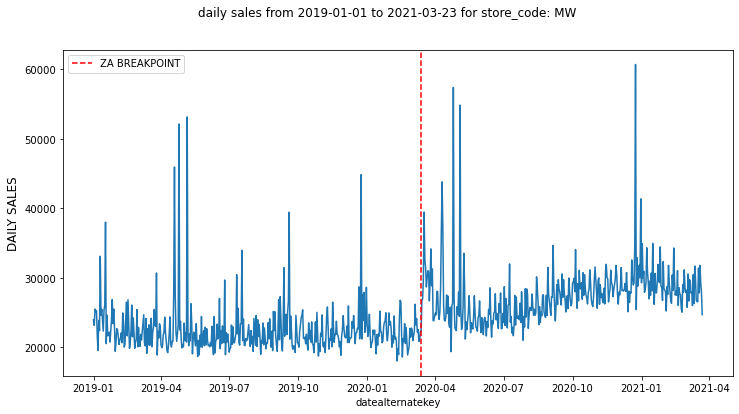

In [13]:
# grab min and max of time index:
date_min_str = str(daily_data_date_df.index.min())
date_min_strptime = datetime.strptime(date_min_str, '%Y-%m-%d %H:%M:%S')
date_min = date_min_strptime.strftime('%Y-%m-%d')

date_max_str = str(daily_data_date_df.index.max())
date_max_strptime = datetime.strptime(date_max_str, '%Y-%m-%d %H:%M:%S')
date_max = date_max_strptime.strftime('%Y-%m-%d')

# construct plots
fig, ax1 = plt.subplots(1,1, figsize=(12,6))
fig.suptitle("daily sales from {} to {} for store_code: {}".format(date_min, 
                                                                  date_max,
                                                                  daily_data_date_df.store.iloc[0]))

sns.lineplot(x=daily_data_date_df.index, 
             y='sales', 
             data=daily_data_date_df,  
             palette='winter',
             markers=True,
             dashes=False,
             legend='full',
             ax=ax1)

# apply vertical red line for the Zivot Andrews calculated breakpoint
ax1.set_ylabel("DAILY SALES", fontsize=12)
ax1.axvline(date_location_za_strp, 0, color='r', linestyle='--', label='ZA BREAKPOINT')
ax1_labels=['ZA BREAKPOINT']
handles_1, _ = ax1.get_legend_handles_labels()
ax1.legend(handles=handles_1, labels=ax1_labels)

plt.show()

* Fairly easy to observe that the dynamics of the series after the breakdate are rather different from those from before. A visible upwards trend is now in the data and the period: 2021-01 (as well as the mid 2020-05 section) now exhibit the 3 highest peak values in the data set post breakpoint. 

<a id='initial_data_exploration'></a>

## INITIAL DATA EXPLORATION & AUTO-CORRELATION INTRODUCTION

Another important concept to consider is partial correlation function (PACF), which is a conditional correlation. It is the correlation between two variables under the assumption that we consider the values of some other set of variables. In regression, this partial correlation could be found by correlating the residuals from two different regressions.

In a time series data set, the autocorrelation for a value at a time stamp and another value at a prior time stamp consists of both the direct correlation between these two values and indirect correlations. These indirect correlations are a linear function of the correlation of the value under observation, with values at intervening time stamps.

In [ ]:
# two additional imports for the statsmodels plots for ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [63]:
def acf_pacf_subplots(series, sample_length='full', number_lags=None, **kwargs):
    "show side-by-side ACF and PACF plots for selected series with a default lag length of 30"
    
    # set default lags to 30 if not passed
    if number_lags is None:
        number_lags = 30
       
    # check to see if the passed-in series is valid
    if series not in ['sales', 'gp','promosales','baskets','avgbasket','waste','loyaltysales']:
        raise ValueError("The series passed is either illogical or invalid in an ACF/PACF plot: pass a correct timeseries")
    
    # check if passed in sample_length argument is valid, else raise an error and suggestion
    if sample_length not in ['full','post_bp','pre_bp','both_bp']:
        raise ValueError("sample_length must be one of: whole sample [full], post-za breakpoint [post_bp], pre [pre_bp], or both bp [both_bp]")
    
    # return the respective graph based off user defined input for sample length
    if sample_length=='full':
        fig, ax = plt.subplots(1,2, figsize=(13, 6))
        fig.suptitle("full-sample length ACF and PACF plots for series: {}".format(series))
        sm.graphics.tsa.plot_acf(daily_data_date_df[series], lags=number_lags, ax=ax[0])
        sm.graphics.tsa.plot_pacf(daily_data_date_df[series], lags=number_lags, ax=ax[1])
        return plt.show()
    
    if sample_length=='post_bp':
        
        # raise error if a breakpoint sample length was passed without a date
        if kwargs.get("breakpoint_date") is None:
            raise ValueError("must pass in variable ['breakpoint_date'] to use the breakpoint function")        
    
        breakpoint_date = kwargs.get("breakpoint_date")
        
        # construct plot
        fig, ax = plt.subplots(1,2, figsize=(13, 6))
        fig.suptitle("post ZA-breakpoint length ACF and PACF plots for series: {}".format(series))
        
        sm.graphics.tsa.plot_acf(daily_data_date_df[daily_data_date_df.index > breakpoint_date][series], 
                                 lags=number_lags, ax=ax[0])
        
        sm.graphics.tsa.plot_pacf(daily_data_date_df[daily_data_date_df.index > breakpoint_date][series], 
                                  lags=number_lags, ax=ax[1])
        return plt.show()        
    

    if sample_length=='pre_bp':
        
        # raise error if a breakpoint sample length was passed without a date
        if kwargs.get("breakpoint_date") is None:
            raise ValueError("must pass in variable ['breakpoint_date'] to use the breakpoint function")
            
        breakpoint_date = kwargs.get("breakpoint_date")    
        
        # construct plot 
        fig, ax = plt.subplots(1,2, figsize=(13, 6))
        fig.suptitle("post ZA-breakpoint length ACF and PACF plots for series: {}".format(series))
        
        sm.graphics.tsa.plot_acf(daily_data_date_df[daily_data_date_df.index < breakpoint_date][series], 
                                 lags=number_lags, ax=ax[0])
        
        sm.graphics.tsa.plot_pacf(daily_data_date_df[daily_data_date_df.index < breakpoint_date][series], 
                                  lags=number_lags, ax=ax[1])
        return plt.show()  
    
    
    if sample_length=='both_bp':
        
        # raise error if a breakpoint sample length was passed without a date
        if kwargs.get("breakpoint_date") is None:
            raise ValueError("must pass in variable ['breakpoint_date'] to use the breakpoint function")
        
        breakpoint_date = kwargs.get("breakpoint_date")
        
        # reconstruct fig size for 4 plots: 
        fig, ax = plt.subplots(2,2, figsize=(16, 9))
        
        fig.suptitle("both [post & pre] ZA-breakpoints ACF and PACF plot comparisons for series: {}".format(series))
        
        sm.graphics.tsa.plot_acf(daily_data_date_df[daily_data_date_df.index > breakpoint_date][series], 
                                 lags=number_lags, ax=ax[0, 0])
        
        ax[0,0].set_title("post BP ACF")
        
        sm.graphics.tsa.plot_pacf(daily_data_date_df[daily_data_date_df.index > breakpoint_date][series], 
                                  lags=number_lags, ax=ax[0, 1])
        
        ax[0,1].set_title("post BP PACF")
        
        # pre breakpoint plots 
        sm.graphics.tsa.plot_acf(daily_data_date_df[daily_data_date_df.index < breakpoint_date][series], 
                                 lags=number_lags, ax=ax[1,0])
        
        ax[1,0].set_title("pre BP ACF")
        
        sm.graphics.tsa.plot_pacf(daily_data_date_df[daily_data_date_df.index < breakpoint_date][series], 
                                  lags=number_lags, ax=ax[1,1])
        
        ax[1,1].set_title("pre BP PACF")
        
        return plt.show()      
    
    
    

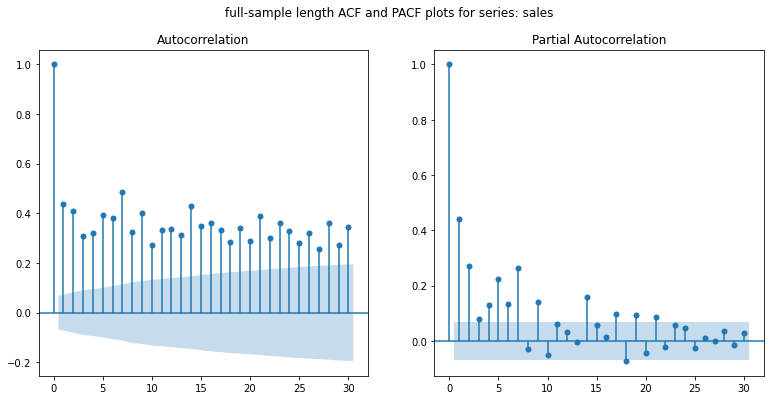

In [64]:
# show the ACF and PACF on the entire sample (2019-2021)
acf_pacf_subplots('sales')

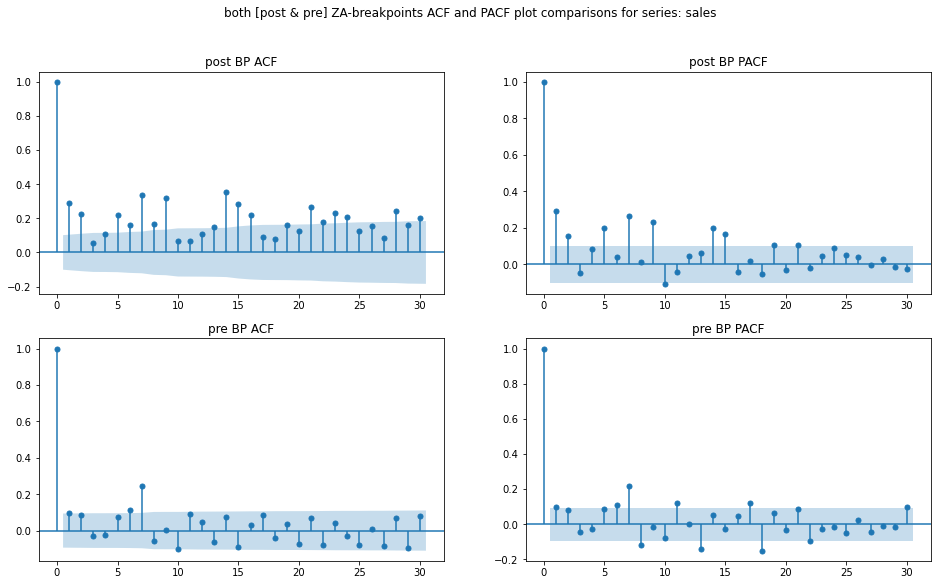

In [65]:
# show pre-break point and post-breakpoint ACF and PACF side-by-side for comparison
acf_pacf_subplots('sales', sample_length='both_bp',breakpoint_date=date_location_za_clean)

## ACF / PACF OBSERVATIONS 

#### FULL-SAMPLE
* comparing the first ACF/PACF plot, there is extreme persistence in the autocorrelation from day-to-day, which would be a strong initial indication of a stationary dataset (although a proper statistical test is still necessary later). 
    * The PACF indicates strong weekly correlation, which makes sense given that particular days of the week are likely to be strong correlated with the same day in the previous week E.G. Sunday to Sunday
    * However, the full-sample PACF also has strong (well above the confidence interval) partial autocorrelation for various, seemingly random lag lengths-- this is possibly attributable to days of the week (E.G. monday / tuesday / wednesday ) affecting each one of the same days in the following week, as week-days tend to exhibit the same kinds of consumer behaviour. 
    
#### ZA-BREAKPOINT SPLIT 
* We notice a lot of the persistent autocorrelation in the pre-breakpoint ACF disappears; the partial ACF phenomena in lags of (7) remains however. This might suggest daily sales from week to week tend to flucuate / be more volatile than what is found in the post-BP sub-sample
* The post-BP has significantly stronger AC, with lags (1-2) becoming significant again; moreover, the PACF 7 day consistency is also present although some of that "seemingly" random PACF phenomena reemerges. This might possibly suggest the same phenomena described above about saturday > sunday or weekdays being fairly similar regarding consumer purchasing behaviour between Monday to Wednesdays, for instance. 
    * The tendency for the PACF to fade out quicker than 

In [38]:
class timeseries_tools:
    
    def __init__(self, data_series):
        self.data_series = data_series
        
    def check_stationarity(self, dfgls_max_lags=None):
        "Return the DFGLS test for a univaraite process: default max lags is 14 days // 2 weeks"
            
        if isinstance(dfgls_max_lags, type(None)):
            dfgls_max_lags = 14
        
        dfgls_model = DFGLS(self.data_series, max_lags=dfgls_max_lags, method='BIC')
        
        return [dfgls_model.stat, dfgls_model.critical_values['5%']]
    
    def stat_boolean(self):
        
        if self.check_stationarity()[0] <= self.check_stationarity()[1]:
            print("series is stationary")
        else:
            print("series is non-stationary")
            
    ## probably remove as the arima model will test the integration order [0, 1]
    

In [39]:
ts_tools = timeseries_tools(daily_data_df['sales'])
ts_tools.check_stationarity()

[-3.2445954510692285, -1.970258110825267]

In [37]:
ts_tools.check_stationarity()[0]

-3.2445954510692285

In [40]:
ts_tools.stat_boolean()

series is stat


In [ ]:
## consider adding: 
if _ is (X): 
    warnings.warn(
    "....", 
    FutureWarning,)
    
    #https://www.statsmodels.org/stable/_modules/statsmodels/tsa/stattools.html#pacf

## NOTES ON TRAIN/TEST SPLIT SIZE
* Provided the general business problem was establishing a forward-looking 1m forecast for purchase budgeting, the sales forecasts had to be locked in 1m in advance
    * Accordingly, an initial point for these budgets was to utilise a train/test split that gives a test size of roughly 1m as the option to do walk-forward validation is not available in practice
    * This results in a 92% training size to a 8% test size, which is roughly (345 to 30 observations respectively)
    

* There is also the added issue of December (Christmas) + Christmas in Covid, having a skewed effect on the test size if the training size is too small and being dominated by the above average December period


* NOTE: the "daily_postbf_df" is defined from the ZA-breakpoint (defined above) or follow this link: [to_za_breakpoint](#sub_sampling) 

In [93]:
# set a training/test split to 92% / 8% -- that way the test size is roughly 1m 
training_size_percent = 0.92

# use floor to ensure values are integers 
training_size = np.floor(len(daily_postbp_df) * training_size_percent)

print(" training size: {} \n test size: {}".format(int(training_size), 
                                                     int(len(daily_postbp_df) - training_size)))

split_date = daily_postbp_df.index[0] + pd.DateOffset(training_size)

daily_postpb_train = daily_postbp_df.loc[daily_postbp_df.index < split_date]
daily_postb_test = daily_postbp_df.loc[daily_postbp_df.index >= split_date]

 training size: 345 
 test size: 30


In [94]:
daily_postpb_train.tail(3)

,store,sales,gp,promosales,promosales,baskets,avgbasket,waste,markdown,items,normalqty,promoqty,loyaltysales,costadjustment,gst,publichol
datealternatekey,,,,,,,,,,,,,,,,
2021-02-19,MW,"26,024.62","5,786.80","12,273.13",0.47,1354,19.22,32.45,258.96,5242,"2,784.35","2,216.89",861.98,91.32,"1,478.49",0
2021-02-20,MW,"28,570.45","6,063.46","13,303.86",0.47,1444,19.79,245.51,490.99,5583,"2,922.33","2,317.02",821.73,-343.87,"1,513.97",0
2021-02-21,MW,"27,667.87","6,588.10","13,206.88",0.48,1339,20.66,489.45,322.03,5812,"3,071.46","2,389.17",732.69,276.26,"1,476.60",0


In [95]:
daily_postb_test.head(3)

,store,sales,gp,promosales,promosales,baskets,avgbasket,waste,markdown,items,normalqty,promoqty,loyaltysales,costadjustment,gst,publichol
datealternatekey,,,,,,,,,,,,,,,,
2021-02-22,MW,"27,605.25","6,767.90","12,910.30",0.47,1324,20.85,27.58,170.80,5635,"3,057.31","2,183.59","1,181.88",-148.03,"1,495.54",0
2021-02-23,MW,"25,594.30","5,839.91","11,310.23",0.44,1332,19.21,13.31,146.63,4815,"8,937.30","1,918.94",989.24,-114.26,"1,340.16",0
2021-02-24,MW,"25,040.84","5,836.96","10,900.06",0.44,1321,18.96,9.44,289.38,5015,"2,836.36","1,867.37",848.74,-109.51,"1,413.53",0


## PICKLE THE TRAIN/TEST SETS [OPTIONAL]

In [19]:
#daily_postpb_train.to_pickle("./daily_postpb_train.pkl")
#daily_postb_test.to_pickle("./daily_postb_test.pkl")

<a id='forecasting_intro'></a>

# FORECAST INTRODUCTION

In [10]:
# 
model_results_dict = {}
model_predictions_dict = {}

In [82]:
# convert to tabulate! 

def evaulate_model_forecast(yhat_values, tester_df_values):
    
    print("Root Mean Squared Error (RMSE): {}".format(np.round(
        mean_squared_error(yhat_values, tester_df_values, squared=False)),4),'\n', "--"*25, '\n')
    
    #print("Mean Absolute Percentage Error (MAPE): {:.2}%".format(
    #    mean_absolute_percentage_error(yhat_values, tester_df_values) *100), '\n', "--"*25, '\n')   
    
    mape = mean_absolute_percentage_error(yhat_values, tester_df_values) * 100
    print("Mean Absolute Percentage Error (MAPE): {}%".format(np.round(mape,2)), '\n', "--"*25, '\n')    
    
    
    print("Mean Absolute Erorr (MAE): {}".format(np.round(
        mean_absolute_error(yhat_values, tester_df_values)),4),'\n', "--"*25, '\n')

In [9]:
def store_model_forecast(yhat_values, tester_df_values):
    """
    return the model evaulation metrics to be stored in a dictionary for model comparison 
    """
    
    mse = np.round(mean_squared_error(yhat_values, tester_df_values, squared=False),4)
    mape = np.round(mean_absolute_percentage_error(yhat_values, tester_df_values) * 100, 2)
    mae = np.round(mean_absolute_error(yhat_values, tester_df_values),4)
    
    return mse, mape, mae
    

## rename or drop one of the promosales columns! (DUPLICATES)

In [6]:
daily_data_date_df.head()

,store,sales,gp,promosales,promosales,baskets,avgbasket,waste,markdown,items,normalqty,promoqty,loyaltysales,costadjustment,gst,publichol
datealternatekey,,,,,,,,,,,,,,,,
2019-01-01,MW,"23,935.00","5,185.96","10,006.91",0.42,1251,19.13,78.27,138.66,4822,"2,912.33","1,703.68",563.81,688.07,"1,204.91",1
2019-01-02,MW,"23,143.62","5,040.71","8,577.01",0.37,1249,18.53,631.34,52.22,4593,"2,900.68","1,361.61",455.57,"-1,957.71","1,178.69",0
2019-01-03,MW,"25,507.01","4,930.69","8,092.75",0.32,1319,19.34,136.37,92.87,4416,"2,822.38","1,325.85",405.81,57.36,"1,145.91",0
2019-01-04,MW,"25,124.87","5,199.56","11,219.92",0.45,1276,19.69,54.79,101.97,4721,"2,806.18","1,704.90",732.95,"1,636.20","1,352.07",0
2019-01-05,MW,"25,241.23","5,437.24","10,073.29",0.40,1328,19.01,66.59,58.32,4844,"2,866.64","1,698.61",284.96,-155.23,"1,295.07",0


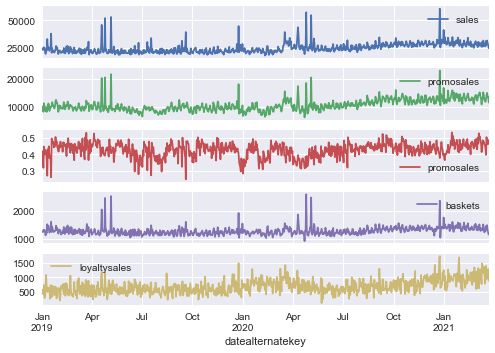

In [10]:
# adjust the fig size! 

plot_cols = ['sales','promosales','baskets','loyaltysales']
plot_features = daily_data_date_df[plot_cols]
plot_features.index = daily_data_date_df.index
_ = plot_features.plot(subplots=True)

<a id='naive_forecast'></a>

# NAIVE FORECAST
* Important to include a naive forecast to measure the "gain" of more complicated models
* Accordingly, it makes little sense to implement a more complicated models if it doesn't involve any significant gain in accuracy Vs. the most simple method (simply predicting the next value to be the mean of the series to date)


In [25]:
# define series mean (sales)
sales_mean_postb = daily_postbp_df.sales.mean()

# convert the entire series mean intro an array of equal length with the mean value as each daily element
sales_mean_postb = np.array([sales_mean_postb for u in range(len(daily_postbp_df))])

In [26]:
evaulate_model_forecast(sales_mean_postb, daily_postbp_df.sales)

Root Mean Squared Error (RMSE): 4187.0 
 -------------------------------------------------- 

Mean Absolute Percentage Error (MAPE): 9.68% 
 -------------------------------------------------- 

Mean Absolute Erorr (MAE): 2666.0 
 -------------------------------------------------- 



* Unsurprisingly, the Naive Forecast performs quite poorly. 
* This is likely because the naive mean can't account for the complexities in the nature of the data; namely, weekends are higher than weekdays, but Mondays might be lower than your average weekday. Furthermore, there are holidays and other special events that aren't captured well by the Naive forecast. Additionally, the naive mean does a poor job capturing the rising trend of the data over the months.

In [27]:
# store the results in a dictionary using the above defined evaulation function
model_results_dict['naive_forecast'] = store_model_forecast(sales_mean_postb, daily_postbp_df.sales)

In [28]:
model_results_dict

{'naive_forecast': (4187.2976, 9.68, 2666.3401)}

In [29]:
model_results_dict['naive_forecast'][1]

9.68

<a id='sarimax'></a>

## SARIMAX: Seasonal Autoregressive Integrated Moving Average (Exogenous Variable: X)
* the base notation for the model is: SARIMAX(p,d,q)(P,D,Q,m)(X)
    * denoting the: Trend Autoregression order, Trend Difference Order, Trend Moving Average Order, (repeated for the seasonal comonent in that order), and the specified exogenous variable (Holidays/Special Events) in this case.


## SARIMAX AUTO 
* The model is initially trained on the training DF, then used to make predictions on the test DF
* pm.auto_arima = A module for iteratively calculating the optimal ARIMA & Seasonal Terms in the SARIMAX environment, subject to user specified restraints and optimisation preferences

#### PARAMETERS EXPLANATION:
* m=7 (seasonality, for daily data (7) = weekly)
* method = 'lbfgs' (optimisation method) is: limited-memory BFGS with optional box constraints
* Stepwise = the stepwise algorithm outlined in Hyndman and Khandakar (2008) 
    * This method of identifying optimal model parameters is significantly faster than fitting all (or a random subset) of hyper-parameter combinations, and is less likely to over-fit the model as a result
* return_valid_fits = will return all valid ARIMA models (these will be later filtered on)
* Information Criterion = how to score each mode, optons are (AIC, BIC, HQIC, OOB)
    * The bic tends to favour less complicated models relative to the AIC, which favours model parsimony
* the max and start (p, P, Q, q, D, d) are the max and starting values for the:
    * p = AR component of the arima model
    * P = AR component of the seasonal component 
    * d = the order of first-differencing for the ARIMA
    * D = the order of first-differencing for the seasonal component 
    * q = MA component of the ARIMA
    * Q = MA component of the seasonal component 
* max_order = maximum integer which is a sum of any of the above mentioned individual model components, set to None meaning no maximum restriction imposed (although individual restraints specified by max_p, max_q etc. do indeed enforce an eventual max_order)
* X = here is an array of (1, 0) which represent public holidays; reshaped(-1, 1) to fit the column-length wise dimensions needed for the data

In [ ]:
# import the auto-(s)arima packages
import pmdarima as pm

In [11]:
## == DF TRAINING == ## 
sarima_auto = pm.auto_arima(daily_postpb_train.sales,
             trace=True,
             error_action='warn',
             seasonal=True,
             m=7,
             stepwise=True,
             method='lbfgs',
             return_valid_fits=True,
             information_criterion='bic',
                           max_p = 5,
                           max_q = 4,
                           max_Q = 4,
                           max_P = 5,
                           max_D = 1,
                           max_d = 1,
                           start_P = 3,
                           start_q = 2,
                           start_Q = 2,
                           start_p = 2,
                           max_order=None,
                           X = np.array(daily_postpb_train.publichol).reshape(-1, 1))

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(3,0,2)[7] intercept   : BIC=6661.527, Time=2.29 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : BIC=6817.811, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : BIC=6722.540, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : BIC=6635.740, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=6812.089, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : BIC=6646.148, Time=0.25 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : BIC=inf, Time=0.74 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : BIC=6633.880, Time=0.89 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : BIC=inf, Time=1.12 sec
 ARIMA(0,1,1)(0,0,3)[7] intercept   : BIC=6640.928, Time=1.30 sec
 ARIMA(0,1,1)(1,0,3)[7] intercept   : BIC=6652.761, Time=1.59 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : BIC=6802.359, Time=0.10 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : BIC=6636.109, Time=1.11 sec
 ARIMA(0,1,2)(0,0,2)[7] intercept   : BIC=6640.225, Time=0.60 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : BIC=6

In [12]:
## print out the top 10 model iterations orders sorted by BIC
top_arima_models_by_bic = []
top_number_models = 10

for i, val in enumerate(sarima_auto[:top_number_models]):
    print(val, val.bic())
    top_arima_models_by_bic.append(val)

 ARIMA(0,1,1)(0,0,2)[7] intercept 6633.880169059311
 ARIMA(0,1,1)(0,0,1)[7] intercept 6635.7401772824915
 ARIMA(1,1,1)(0,0,2)[7] intercept 6636.1087149197365
 ARIMA(0,1,1)(0,0,2)[7]           6637.793511931245
 ARIMA(0,1,2)(0,0,2)[7] intercept 6640.22472525722
 ARIMA(0,1,1)(0,0,3)[7] intercept 6640.928010429546
 ARIMA(0,1,1)(0,0,0)[7] intercept 6646.1480073896455
 ARIMA(0,1,1)(1,0,3)[7] intercept 6652.760958871001
 ARIMA(2,1,2)(3,0,2)[7] intercept 6661.527209530503
 ARIMA(1,1,0)(1,0,0)[7] intercept 6722.5401474956325


## NOTES FOR CHOSING AN INITIAL SARIMAX FORECASTING MODEL
* Be careful to identify that all comparable models are of the same differencing order, otherwise the BIC cannot be directly compared

* We noted earlier in the ACF and PACF that the autoregressive component stays significant for quite a long period, thus, out of the top models, we will likely favour models which have an AR component initially (provided the BIC is not substantially different). Ultimately, the chosen models should be compared in terms of their predictive strength in multiple sub-samples in terms of RMSE / MAE etc.

* We also note that the PACF which showed strong 7x multiple lags (same days affecting the same days from week to week, E.g. Sunday to Sunday) is reflected by the range (1-3) of MA terms in the seasonal part of the model. 

* The ACF plots also show very strong AC, so we will favour a model with a higher AR order to begin

In [15]:
# fit the final model based of the specified SARIMA terms from the top_models_list 

# specify index of the chosen model
model_interation_index = 8

# fit the model iteration to the training data 
sarimax_auto_fitted = top_arima_models_by_bic[model_interation_index].fit(daily_postpb_train.sales)
sarimax_auto_fitted

ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(3, 0, 2, 7),
      suppress_warnings=True)

### WALK-FORWARD PREDICTION
* Allow the prediction to be iteratively updated at each time step
* This is primarily for research and testing purposes, as in reality, submitted forecasts should be finalised for 1M periods in advance and are not changable (in the absence of extreme events) 
    * The subsequent "static" forecast will be the focus / comparable forecast to be used in the final evaulation 

In [23]:
%%time
warnings.filterwarnings("ignore") 

# set the orders to the optimised orders from the auto-sarimax & print for convenience 
ar_order = sarimax_auto_fitted.order
s_order = sarimax_auto_fitted.seasonal_order
print(" ARIMA TERMS: {} \n SEASONAL TERMS: {}".format(ar_order, s_order))

# store the model predictions in a list
yhat = []

for i in range(len(daily_postb_test.sales)):
    sales_train = daily_postbp_df[:len(daily_postpb_train) +i]
    
    model_sarimax = sm.tsa.statespace.SARIMAX(sales_train.sales, order=ar_order, seasonal_order=s_order,
                                             exog=sales_train.publichol)
    
    model_sarimax_fitted = model_sarimax.fit()
    
    # note: prediction passes in test DF exog values
    model_sarimax_pred = model_sarimax_fitted.predict(start=len(sales_train), end=len(sales_train), dynamic=True,
                                                     exog=daily_postb_test.publichol[i])
    
    yhat = yhat + [model_sarimax_pred]

# concat the series of 1D walk-forward validation forecasts to get one continuous series of predictions    
yhat = pd.concat(yhat)

 ARIMA TERMS: (2, 1, 2) 
 SEASONAL TERMS: (3, 0, 2, 7)
Wall time: 1min 6s


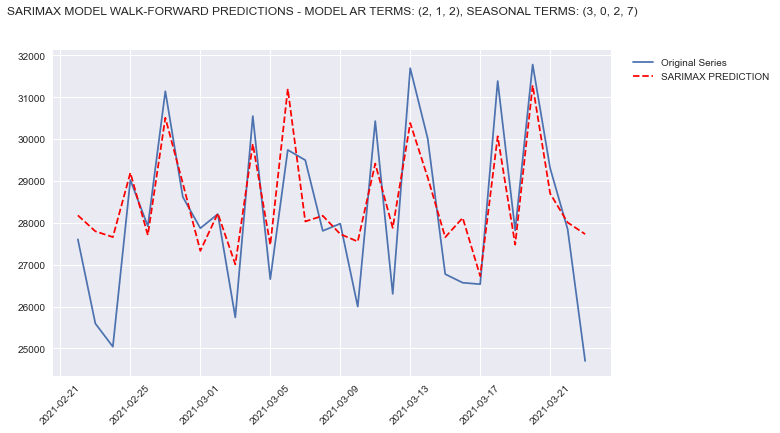

In [24]:
# plot the original data Vs. the walk-forard prediction in SARIMAX
fig, ax = plt.subplots(1,1, figsize=(10,6))
fig.suptitle("SARIMAX MODEL WALK-FORWARD PREDICTIONS - MODEL AR TERMS: {}, SEASONAL TERMS: {}".format(
sarimax_auto_fitted.order, sarimax_auto_fitted.seasonal_order))
plt.plot(daily_postb_test.index, daily_postb_test.sales.values, label='Original Series')
plt.plot(daily_postb_test.index, yhat.values, color='red', label='SARIMAX PREDICTION', linestyle="--")
plt.xticks(rotation='45')[::2]
plt.legend(bbox_to_anchor=(1.30, 1), loc='upper right')
plt.show();

### SARIMAX WALK-FORWARD PREDICTION INSIGHTS

#### RECALL: this model could not be used in reality, but it simply a broad oversight of how daily sales could be predicted if the values were allowed to be updated daily
* The model seems to capture the weekend (seasonality 7D to 7D phenomena) reasonably well
* However, it seems to consistenly overpredict the mid-week drops


In [31]:
## quick print model evaluation
evaulate_model_forecast(daily_postb_test.sales.values, yhat.values)

Root Mean Squared Error (RMSE): 1205.0 
 -------------------------------------------------- 

Mean Absolute Percentage Error (MAPE): 3.48% 
 -------------------------------------------------- 

Mean Absolute Erorr (MAE): 952.0 
 -------------------------------------------------- 



In [32]:
# store the results in a dictionary using the above defined evaulation function
model_results_dict['walkfwd_sarimax'] = store_model_forecast(daily_postb_test.sales.values, yhat.values)

<a id='static_sarimax'></a>

## STATIC SARIMAX
* As previously mentioned, the ability to perform a walk-forward validation is not feasible in reality, as 1M forecasts must be submitted ahead of time to be passed to individual stores
* Hence, we also should test how the model performs with 1M forward, static predictions that don't update with each day's previous values

In [85]:
warnings.filterwarnings("ignore") 
# static 1m forecast

ar_order = sarimax_auto_fitted.order
s_order = sarimax_auto_fitted.seasonal_order
print(" ARIMA TERMS: {} \n SEASONAL TERMS: {}".format(ar_order, s_order))
   
model_sarimax = sm.tsa.statespace.SARIMAX(daily_postbp_df.sales, 
                                          order=ar_order, 
                                          seasonal_order=s_order,
                                          exog=daily_postbp_df.publichol)
    
model_sarimax_fitted = model_sarimax.fit()


model_sarimax_pred = model_sarimax_fitted.predict(30)
    

 ARIMA TERMS: (2, 1, 2) 
 SEASONAL TERMS: (3, 0, 2, 7)


In [86]:
model_sarimax_pred

2020-04-13   33,363.07
2020-04-14   25,885.91
2020-04-15   26,666.61
2020-04-16   28,393.70
2020-04-17   26,272.34
                ...   
2021-03-19   27,454.37
2021-03-20   31,326.41
2021-03-21   28,644.16
2021-03-22   28,048.44
2021-03-23   27,648.00
Freq: D, Name: predicted_mean, Length: 345, dtype: float64

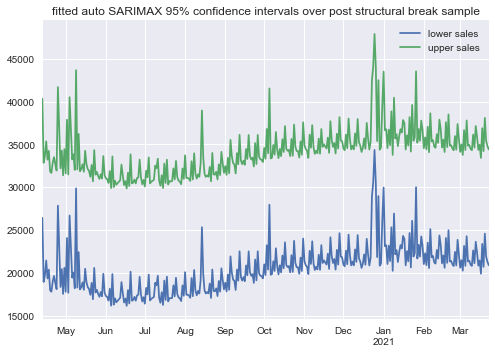

In [87]:
# can get confidence intervals at 95%, but they're too broad to be practical due to natural  
model_sarimax_fitted.get_prediction(30).conf_int(95).plot()
plt.title("fitted auto SARIMAX 95% confidence intervals over post structural break sample");

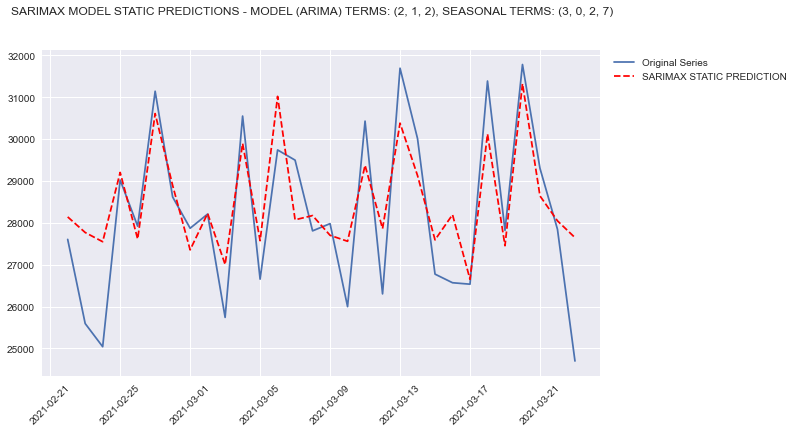

In [88]:
# graph static prediction vs real series
fig, ax = plt.subplots(1,1, figsize=(10,6))
fig.suptitle("SARIMAX MODEL STATIC PREDICTIONS - MODEL (ARIMA) TERMS: {}, SEASONAL TERMS: {}".format(
sarimax_auto_fitted.order, sarimax_auto_fitted.seasonal_order))
plt.plot(daily_postb_test.index, daily_postb_test.sales.values, label='Original Series')
plt.plot(daily_postb_test.index, model_sarimax_pred[-30:], color='red', label='SARIMAX STATIC PREDICTION', linestyle="--")
plt.xticks(rotation='45')[::2]
plt.legend(bbox_to_anchor=(1.35, 1), loc='upper right')
plt.show();

### STATIC SARIMAX INSIGHTS: 
* 

In [89]:
## quick print model evaluation
evaulate_model_forecast(model_sarimax_pred[-30:], daily_postb_test['sales'][-30:])

Root Mean Squared Error (RMSE): 1180.0 
 -------------------------------------------------- 

Mean Absolute Percentage Error (MAPE): 3.3% 
 -------------------------------------------------- 

Mean Absolute Erorr (MAE): 936.0 
 -------------------------------------------------- 



In [37]:
# store the results in a dictionary using the above defined evaulation function
model_results_dict['static_sarimax'] = store_model_forecast(model_sarimax_pred[-30:], 
                                                            daily_postb_test['sales'][-30:])

# COMMENT 

In [76]:
warnings.filterwarnings("ignore") 
# static 1m forecast

ar_order = sarimax_auto_fitted.order
s_order = sarimax_auto_fitted.seasonal_order
print(" ARIMA TERMS: {} \n SEASONAL TERMS: {}".format(ar_order, s_order))
   
model_sarimax = sm.tsa.statespace.SARIMAX(daily_postpb_train.sales, 
                                          order=ar_order, 
                                          seasonal_order=s_order,
                                          exog=daily_postpb_train.publichol)
    
model_sarimax_fitted = model_sarimax.fit()


model_sarimax_fcast = model_sarimax_fitted.forecast(steps=30, exog=daily_postb_test.publichol)
    

 ARIMA TERMS: (2, 1, 2) 
 SEASONAL TERMS: (3, 0, 2, 7)


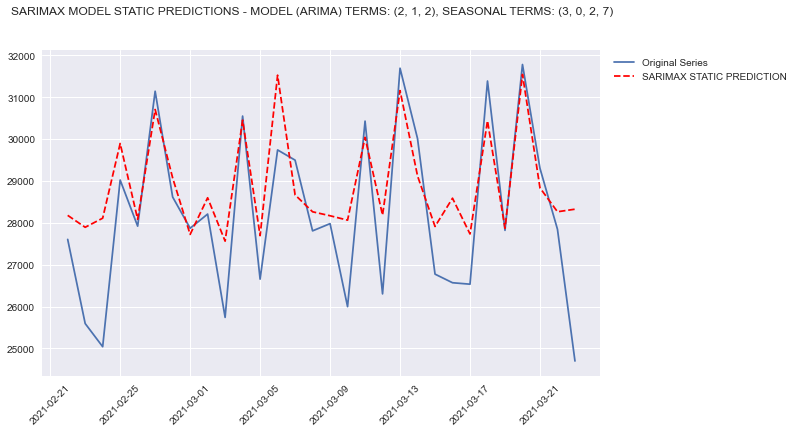

In [77]:
# graph static prediction vs real series
fig, ax = plt.subplots(1,1, figsize=(10,6))
fig.suptitle("SARIMAX MODEL STATIC PREDICTIONS - MODEL (ARIMA) TERMS: {}, SEASONAL TERMS: {}".format(
sarimax_auto_fitted.order, sarimax_auto_fitted.seasonal_order))
plt.plot(daily_postb_test.index, daily_postb_test.sales.values, label='Original Series')
plt.plot(daily_postb_test.index, model_sarimax_fcast[-30:], color='red', label='SARIMAX STATIC PREDICTION', linestyle="--")
plt.xticks(rotation='45')[::2]
plt.legend(bbox_to_anchor=(1.35, 1), loc='upper right')
plt.show();

In [78]:
## quick print model evaluation
evaulate_model_forecast(model_sarimax_fcast[-30:], daily_postb_test['sales'][-30:])

Root Mean Squared Error (RMSE): 1358.0 
 -------------------------------------------------- 

Mean Absolute Percentage Error (MAPE): 3.56% 
 -------------------------------------------------- 

Mean Absolute Erorr (MAE): 1017.0 
 -------------------------------------------------- 



In [ ]:
# store the results in a dictionary using the above defined evaulation function
model_results_dict['static_sarimax'] = store_model_forecast(model_sarimax_fcast[-30:], 
                                                            daily_postb_test['sales'][-30:])

<a id='tbats'></a>

## TBATS 
* A strong model for capturing multiple seasonalities, however, it cannot handle special exogenous variables that don't fit a usual pattern very well. 
* There is room for a hybrid model to use TBATS for non-holiday days, and use an ARIMAX model to capture the holiday/special event sales days accordingly


### PARAMETER EXPLANATION
* T = trigonometric regressions to model multiple seasonalities 
* B = Box-Cox Transformations
* A = ARMA errors
* T = Trend
* S = Seasonality 


* The TBATS is a time series model for modeling series which exhibit multiple complex seasonalities. 
* SOURCE:
    * https://github.com/intive-DataScience/tbats

In [ ]:
# IDEA BE: 

# use tbats for when holiday==1; else use TBATS? 
# run a seperate tbats model with the holidays removed?

In [47]:
from tbats import TBATS

In [48]:
see(TBATS)

    isclass          <                <=               ==               !=               >                >=
    dir()            hash()           help()           repr()           str()
    .create_most_complex_components()                  .fit()           .get_params()    .set_params()

In [65]:
## based off PACF; load 2 seasonality periods 
tbats_estimator = TBATS(seasonal_periods=[7, 14])

fitted_model_tbats = tbats_estimator.fit(daily_postpb_train.sales)

In [66]:
fitted_model_tbats.summary()

'Use Box-Cox: True\nUse trend: False\nUse damped trend: False\nSeasonal periods: [ 7. 14.]\nSeasonal harmonics [3 1]\nARMA errors (p, q): (0, 0)\nBox-Cox Lambda 0.000000\nSmoothing (Alpha): 0.099731\nSeasonal Parameters (Gamma): [-2.07e-08  6.65e-08  1.44e-07  3.26e-07]\nAR coefficients []\nMA coefficients []\nSeed vector [ 1.03e+01  4.98e-02  1.40e-02  4.20e-02 -1.87e-02  6.29e-03  2.54e-02\n  6.92e-03 -1.25e-03]\n\nAIC 7539.950299'

In [67]:
## quick print model evaluation
evaulate_model_forecast(fitted_model_tbats.y_hat[-30:], daily_postb_test['sales'][-30:])

Root Mean Squared Error (RMSE): 2601.0 
 -------------------------------------------------- 

Mean Absolute Percentage Error (MAPE): 7.14% 
 -------------------------------------------------- 

Mean Absolute Erorr (MAE): 2131.0 
 -------------------------------------------------- 



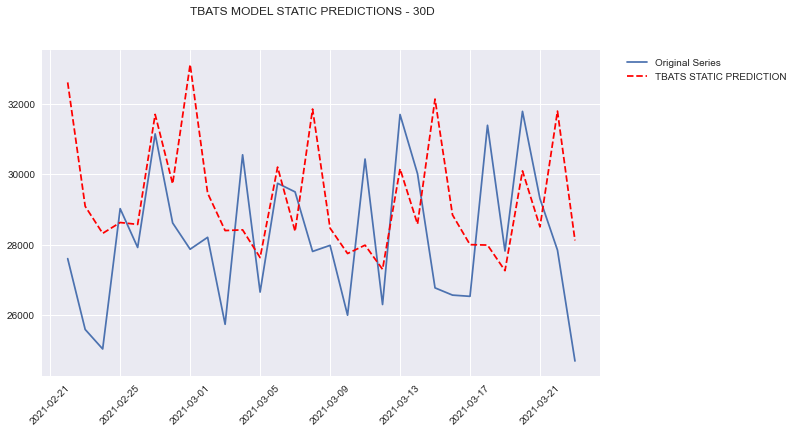

In [68]:
# graph static prediction vs real series
fig, ax = plt.subplots(1,1, figsize=(10,6))
fig.suptitle("TBATS MODEL STATIC PREDICTIONS - 30D")

plt.plot(daily_postb_test.index, daily_postb_test.sales.values, label='Original Series')
plt.plot(daily_postb_test.index, fitted_model_tbats.y_hat[-30:], color='red', label='TBATS STATIC PREDICTION', linestyle="--")
plt.xticks(rotation='45')[::2]
plt.legend(bbox_to_anchor=(1.35, 1), loc='upper right')
plt.show();

In [62]:
daily_postbp_df

,store,sales,gp,promosales,promosales,baskets,avgbasket,waste,markdown,items,normalqty,promoqty,loyaltysales,costadjustment,gst,publichol
datealternatekey,,,,,,,,,,,,,,,,
2020-03-14,MW,"26,745.06","5,697.23","11,807.97",0.44,1370,19.52,56.52,112.74,5318,"2,940.77","2,096.13",900.02,-271.82,"1,415.80",0
2020-03-15,MW,"26,936.37","6,138.36","12,659.66",0.47,1311,20.55,17.96,163.17,6102,"3,290.31","2,508.90","1,013.53",-68.24,"1,368.60",0
2020-03-16,MW,"29,731.74","7,249.34","11,685.05",0.39,1256,23.67,11.72,32.34,6563,"3,805.93","2,413.77",976.12,370.06,"1,415.02",0
2020-03-17,MW,"39,464.43","9,583.75","15,454.67",0.39,1562,25.27,49.20,24.37,8841,"5,279.28","3,201.87","1,114.27","1,123.82","1,768.26",0
2020-03-18,MW,"32,555.20","7,997.82","12,644.51",0.39,1473,22.10,15.31,16.93,7585,"4,485.02","2,776.32","1,423.27",-428.02,"1,481.99",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-19,MW,"27,821.64","5,854.11","14,035.31",0.50,1340,20.76,253.03,209.94,4971,"2,546.63","2,167.46",937.27,"1,373.91","1,652.34",0
2021-03-20,MW,"31,784.66","6,776.58","14,893.82",0.47,1493,21.29,153.83,369.74,5837,"3,100.67","2,384.89","1,037.16",-242.78,"1,684.62",0
2021-03-21,MW,"29,303.51","6,976.33","13,508.61",0.46,1307,22.42,245.68,417.32,6019,"3,307.21","2,367.75","1,197.04",7.39,"1,527.87",0


In [74]:
daily_postpb_train.tail(3)

,store,sales,gp,promosales,promosales,baskets,avgbasket,waste,markdown,items,normalqty,promoqty,loyaltysales,costadjustment,gst,publichol
datealternatekey,,,,,,,,,,,,,,,,
2021-02-19,MW,"26,024.62","5,786.80","12,273.13",0.47,1354,19.22,32.45,258.96,5242,"2,784.35","2,216.89",861.98,91.32,"1,478.49",0
2021-02-20,MW,"28,570.45","6,063.46","13,303.86",0.47,1444,19.79,245.51,490.99,5583,"2,922.33","2,317.02",821.73,-343.87,"1,513.97",0
2021-02-21,MW,"27,667.87","6,588.10","13,206.88",0.48,1339,20.66,489.45,322.03,5812,"3,071.46","2,389.17",732.69,276.26,"1,476.60",0


In [75]:
daily_postb_test.head(3)

,store,sales,gp,promosales,promosales,baskets,avgbasket,waste,markdown,items,normalqty,promoqty,loyaltysales,costadjustment,gst,publichol
datealternatekey,,,,,,,,,,,,,,,,
2021-02-22,MW,"27,605.25","6,767.90","12,910.30",0.47,1324,20.85,27.58,170.80,5635,"3,057.31","2,183.59","1,181.88",-148.03,"1,495.54",0
2021-02-23,MW,"25,594.30","5,839.91","11,310.23",0.44,1332,19.21,13.31,146.63,4815,"8,937.30","1,918.94",989.24,-114.26,"1,340.16",0
2021-02-24,MW,"25,040.84","5,836.96","10,900.06",0.44,1321,18.96,9.44,289.38,5015,"2,836.36","1,867.37",848.74,-109.51,"1,413.53",0


<a id='xgboost'></a>

# XGBOOST (eXtreme Gradient Boosting)

* In a nutshell, the XGBoost package will implement the gradient boosting decision tree algorithm. boosting is an ensemble technique where new models are added to correct the errors made by existing (previous) models, these models are added sequentially until no further improvements can be made. The gradient boosting refers to the approach in that new models aim to predict the residuals (errors) of prior models, and then are added together to make the final prediction; the gradient boosting gets its name from the fact it uses a gradient descent algorithm to minimise the loss when adding the newer models

### Three types of parameters before running the XGBoost model:
* General Parameters
    * E.G. which booster to use: tree or linear model etc.
* Boosting Parameters
    * Parameter Explanations are available in the packages docs
    * https://xgboost.readthedocs.io/en/latest/tutorials/model.html
* Learning Task Parameters:
    * which depend on the learning scenario, E.G. regression taks may use different criteria to evaulate their accuracy vs classification problems etc. 

    
    


In [28]:
# may need to pip install xgboost 
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from xgboost import plot_importance

In [6]:
# read pickle files [optional if not already executed above]
daily_postpb_train = pd.read_pickle("./daily_postpb_train.pkl") 
daily_postb_test = pd.read_pickle("./daily_postb_test.pkl") 

<a id='feature_engineering'></a>

## FEATURE ENGINEERING 


### Create Time-Series Features & Filter DF to simplify for un-needed model inputs in the subsequent models 
* It might be tempting to include "baskets" which would give an incredibly accurate forecast, however, this would overlook the fact that an out-of-sample forecast will not have an accurate value for "baskets" (transactions) and thus, this model would not perform well out of sample. 

In [7]:
## restrict to just necessary univariate sales + exog variable publichol
train_df_x = daily_postpb_train[['sales','publichol']]
test_df_x = daily_postb_test[['sales','publichol']]

### ADD UNIQUE TIME SERIES FEATURE: DAYS SINCE LAST PUBLIC-HOL

In [ ]:
## add a few time features to our model -- should be based off logic regarding the available time frequency of the data

In [ ]:
### ADD in time series feature (days since last public hol)?
## or add "weekends" 

In [84]:

def construct_time_features(df,target=None):
    """ Creates a host of time series features from a datetime index, 
    moves the "target" variable into a seperate series when called """
    
    # specify a date variable (which is the index of this DF; else, can call reset_index() first)
    df['date'] = df.index
    
    # using datetime package, extract various time features relating to the (daily) base-level data
    df['dayofweek'] = df['date'].dt.dayofweek
    
    #df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    ## ==  other potential options - not relevant if the sample period is too short == ##
    #df['month'] = df['date'].dt.month
    #df['dayofyear'] = df['date'].dt.dayofyear
    #df['quarter'] = df['date'].dt.quarter
    #df['year'] = df['date'].dt.year
    
    # == useful if hourly data == # 
    ## note: the (sine, cosine) transformation of the time of day variable ensure that E.G. 0 and 23H are close to each other
    #df['hour'] = df['date'].dt.hour
    
    #df['sin_day'] = np.sin(df['dayofyear'])
    #df['cos_day'] = np.cos(df['dayofyear'])
    
    # drop the transient date column now the features are done
    X = df.drop(['date'],axis=1)
    
    # E.G. if target=sales, move this target variable from the original DF, and specify it as 2nd parameter (y)
    # this will effectively move it so it's own single-variable series when the function is called with target!= none
    if target:
        y = df[target]
        X = X.drop([target],axis=1)
        return X, y
    
    return X

In [85]:
# data / time series features to feed into models:
scaled_train_df_x, y_train = construct_time_features(train_df_x, target='sales')
scaled_test_df_x, y_test = construct_time_features(test_df_x, target='sales')

In [86]:
## == [NOT INCLUDED IN FINAL MODEL] - ITERATION WAS UNSUCCESSFUL  == ## 

# add a weekend indicator to the dayofweek to attempt to correct the underfitting of weekends 
scaled_train_df_x['weekend'] = scaled_train_df_x.dayofweek.apply(lambda x: 1 if x ==(5) or x ==(6) else 0)

# repeat for test DF 
scaled_test_df_x['weekend'] = scaled_test_df_x.dayofweek.apply(lambda x: 1 if x ==(5) or x ==(6) else 0)

In [87]:
#E.G. of training DF 
scaled_train_df_x

,publichol,dayofweek,weekofyear,weekend
datealternatekey,,,,
2020-03-14,0,5,11,1
2020-03-15,0,6,11,1
2020-03-16,0,0,12,0
2020-03-17,0,1,12,0
2020-03-18,0,2,12,0
...,...,...,...,...
2021-02-17,0,2,7,0
2021-02-18,0,3,7,0
2021-02-19,0,4,7,0


In [ ]:
## ADD SCARSE MATRIX REPRESENTATION FOR PUBLIC HOL / WEEKENDS? 

In [112]:
# normalisation 
scaler = StandardScaler(with_mean=True)
scaler.fit(scaled_train_df_x)

StandardScaler()

In [113]:
X_train = scaler.transform(scaled_train_df_x)
X_test = scaler.transform(scaled_test_df_x)

In [114]:
X_train_df = pd.DataFrame(X_train, columns=scaled_train_df_x.columns)
X_test_df = pd.DataFrame(X_test, columns=scaled_test_df_x.columns)

In [115]:
X_train_df.head()

,publichol,dayofweek,weekofyear,weekend
0,-0.22,0.99,-1.15,1.57
1,-0.22,1.49,-1.15,1.57
2,-0.22,-1.50,-1.09,-0.64
3,-0.22,-1.01,-1.09,-0.64
4,-0.22,-0.51,-1.09,-0.64


In [ ]:
# sparse matrix rep? 

###  before fitting and predicting the model - we should tune for the optimal parameters

<a id='xgboost_param_tuning'></a>


## GENERAL APPROACH TO PARAMETER TUNING IN XGBOOST

* objective = "regression" and "squared error" thus denoted: "reg:squarederror"

* 1) Tune the learning rate (starting from a relatively higher point ~ 0.5); can use the XGBoost package's function called "cv" which can return the optimum number of required trees by performing cross validation at each iteration
    * Refers to the step size shrinkage used in update to prevent overfitting; the learning rate shrinks the feature weights (after each boosting step, directly get the weights of the new features) to make the boosting process more conservative 


* 2) Tune tree-specific parameters for the decided learning rate and number of trees:
    * min_child_weight
        * minimum sum of instance weight needed in a child; if a partitioning step in a tree results in a leaf node with the sum of the instance weight being less than the min_child_weight specified value, the building process will cease further partitioning. The larger the value, the more conservative the algorithm. 
            * the smaller the value, the leaf nodes can have smaller sized groups 
    * max_depth
        * Increasing this value makes a model more complex and consequently, more likely to overfit
            * values range from (3-10); (4-6) is a good starting point
    * gamma
        * Minimum loss reduction required to make a futher partition on a leaf node of the tree; a larger gamma is a more conservative algorithm
            * Starting value (0.1 - 0.2) 
    * subsample
        * The subsample ratio of the training instances; subsampling occurs once in every boosting iteration, setting a value to 0.5 would randomly sample half of the training data prior to growing the trees- which would assist in preventing overfitting 
    * colsample_by_tree
        * The subsample ratio of columns when constructing each tree
            * Values range from (0.5 - 0.9)
    
    
* 3) Tune regularisation parameters: performance improvements / reduction in model complexiy: Both are regularisation terms on weights, increasing either value will make the model more conservative 
    * alpha (L1) (labelled: 'reg_alpha') 
    * lambda (L2) (labelled: 'reg_lambda')
    
    
* 4) Lower the learning rate and decide upon the optimal parameters for the model to be used in forecasting

## Tune "max_deph" and "min_child_weight" 
* NOTE: due to the large amount of potential models / tuning, the n_estimators will be temporarily lowered to 140 to reduce the computational time; depending on your system / available time, this parameter could be adjusted according 

In [14]:
%%time
#Grid seach on subsample and min_child_weight (param_test_1)
# first test will have a wider range of (2); e.g. min_child_weight = (1,3,5)

param_test_1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)}

gsearch_1 = GridSearchCV(estimator = xgb.XGBClassifier(objective = 'reg:squarederror',
                                n_estimators=140,
                                learning_rate=0.1,
                                min_child_weight=1,
                                gamma=0,
                                reg_lambda=1,
                                reg_alpha=0,
                                min_split_loss=1,
                                max_depth=5,
                                subsample=0.8,
                                colsample_bytree=0.8),
                       param_grid = param_test_1, 
                         scoring='roc_auc', 
                         n_jobs=4, 
                         cv=5)

# note, seed default = 0
gsearch_1.fit(X_train, y_train)

[17:57:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 2min 15s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=5, min_child_weight=1,
                                     min_split_loss=1, missing=nan,
                                     monotone_constraints=None,
                                     n_estimators=140, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='reg:squarederror',
                                     random_state=None, reg_alpha=0,
                                     re

In [15]:
# print grid-search (#1) optimisation best values 
gsearch_1.best_params_, gsearch_1.best_score_

({'max_depth': 3, 'min_child_weight': 1}, nan)

## Further refine the step size to be more narrow at the lower end of the scale for each metric
* NOTE: this could be combined with the first param_test_1 depending on your system

In [69]:
param_test_2 = {
    'max_depth':range(3,5,1),
    'min_child_weight':range(1,3,1)}

gsearch_2 = GridSearchCV(estimator = xgb.XGBClassifier(objective = 'reg:squarederror',
                                n_estimators=140,
                                learning_rate=0.1,
                                min_child_weight=1,
                                gamma=0,
                                reg_lambda=1,
                                reg_alpha=0,
                                min_split_loss=1,
                                max_depth=5,
                                subsample=0.8,
                                colsample_bytree=0.8),
                       param_grid = param_test_2, 
                         scoring='roc_auc', 
                         n_jobs=4, 
                         cv=5)

gsearch_2.fit(X_train, y_train)

[16:20:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=5, min_child_weight=1,
                                     min_split_loss=1, missing=nan,
                                     monotone_constraints=None,
                                     n_estimators=140, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='reg:squarederror',
                                     random_state=None, reg_alpha=1,
                                     re

In [70]:
# print grid-search (#2) optimisation best values 
gsearch_2.best_params_, gsearch_2.best_score_

({'max_depth': 3, 'min_child_weight': 1}, nan)

In [103]:
# define these variables from the outputed dictionary
optimal_max_depth = list(gsearch_2.best_params_.values())[0]
optimal_min_cw = list(gsearch_2.best_params_.values())[1]

## Further tune "min_child_weight" 
* Check for the upper-range of values for this parameter, leaving max_depth fixed to its optimal value from above

In [106]:
param_test_2b = {
    'min_child_weight':range(6,13,1)}

gsearch_2b = GridSearchCV(estimator = xgb.XGBClassifier(objective = 'reg:squarederror',
                                n_estimators=140,
                                learning_rate=0.1,
                                min_child_weight=optimal_min_cw,
                                gamma=0,
                                reg_lambda=1,
                                reg_alpha=0,
                                min_split_loss=1,
                                max_depth=optimal_max_depth,
                                subsample=0.8,
                                colsample_bytree=0.8),
                       param_grid = param_test_2b, 
                         scoring='roc_auc', 
                         n_jobs=4, 
                         cv=5)

gsearch_2b.fit(X_train, y_train)

[17:24:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=3, min_child_weight=1,
                                     min_split_loss=1, missing=nan,
                                     monotone_constraints=None,
                                     n_estimators=140, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='reg:squarederror',
                                     random_state=None, reg_alpha=0,
                                     re

In [107]:
gsearch_2b.best_params_, gsearch_2b.best_score_

({'min_child_weight': 6}, nan)

In [ ]:
# define the new optimal min_child_weight
optimal_min_cw = list(gsearch_2b.best_params_.values())[1]

## Tune optimal gamma 
* [OPTIONAL] - recalibrate the number of boosting rounds (n_estimators) from 140 to 1000, but this depends on your computing power available, once again

In [108]:
param_test_3 = {
    'gamma':[i/10 for i in range(0, 5, 1)]}

gsearch_3 = GridSearchCV(estimator = xgb.XGBClassifier(objective = 'reg:squarederror',
                                n_estimators=140,
                                learning_rate=0.1,
                                min_child_weight=optimal_min_cw,
                                gamma=0,
                                reg_lambda=1,
                                reg_alpha=0,
                                min_split_loss=1,
                                max_depth=optimal_max_depth,
                                subsample=0.8,
                                colsample_bytree=0.8),
                       param_grid = param_test_3, 
                         scoring='roc_auc', 
                         n_jobs=4, 
                         cv=5)

gsearch_3.fit(X_train, y_train)

[17:26:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=3, min_child_weight=6,
                                     min_split_loss=1, missing=nan,
                                     monotone_constraints=None,
                                     n_estimators=140, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='reg:squarederror',
                                     random_state=None, reg_alpha=0,
                                     re

In [109]:
gsearch_3.best_params_, gsearch_3.best_score_

({'gamma': 0.0}, nan)

In [ ]:
# define the new optimal gamma
optimal_gamma = list(gsearch_3.best_params_.values())[1]

## Tune subsample and colsample_bytree in (2) stages
* depending on your computational power, this step could be combined with the subsequent step for param_test_4b

In [110]:
param_test_4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]}

gsearch_4 = GridSearchCV(estimator = xgb.XGBClassifier(objective = 'reg:squarederror',
                                n_estimators=140,
                                learning_rate=0.1,
                                min_child_weight=optimal_min_cw,
                                gamma=optimal_gamma,
                                reg_lambda=1,
                                reg_alpha=0,
                                min_split_loss=1,
                                max_depth=optimal_max_depth,
                                subsample=0.8,
                                colsample_bytree=0.8),
                       param_grid = param_test_4, 
                         scoring='roc_auc', 
                         n_jobs=4, 
                         cv=5)

gsearch_4.fit(X_train, y_train)

[17:30:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=3, min_child_weight=6,
                                     min_split_loss=1, missing=nan,
                                     monotone_constraints=None,
                                     n_estimators=140, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='reg:squarederror',
                                     random_state=None, reg_alpha=0,
                                     re

In [111]:
gsearch_4.best_params_, gsearch_4.best_score_

({'colsample_bytree': 0.6, 'subsample': 0.6}, nan)

### Refine a more narrow param test around the subsample and colsample_bytree variables
* note: can either pass in the above dict and automatically specify a range; or do it manually depending on how refined you want to be when optimising the parameters
    * Here, I opt to simply hard-code it in

In [ ]:
# do a more narrow param test (0.05) intervals around the previously optimal value
param_test_4b = {
 'subsample':[i/100.0 for i in range(55,70,5)],
 'colsample_bytree':[i/100.0 for i in range(55,70,5)]}

gsearch_4b = GridSearchCV(estimator = xgb.XGBClassifier(objective = 'reg:squarederror',
                                n_estimators=140,
                                learning_rate=0.1,
                                min_child_weight=optimal_min_cw,
                                gamma=optimal_gamma,
                                reg_lambda=1,
                                reg_alpha=0,
                                min_split_loss=1,
                                max_depth=optimal_max_depth,
                                subsample=0.6,
                                colsample_bytree=0.6),
                       param_grid = param_test_4b, 
                         scoring='roc_auc', 
                         n_jobs=4, 
                         cv=5)

gsearch_4b.fit(X_train, y_train)

In [ ]:
# define these variables from the outputed dictionary
optimal_colsample_bytree = list(gsearch_4b.best_params_.values())[0]
optimal_subsample = list(gsearch_4b.best_params_.values())[1]

### Tune for the alpha param

In [112]:
param_test_5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}


gsearch_5 = GridSearchCV(estimator = xgb.XGBClassifier(objective = 'reg:squarederror',
                                n_estimators=140,
                                learning_rate=0.1,
                                min_child_weight=optimal_min_cw,
                                gamma=optimal_gamma,
                                reg_lambda=1,
                                reg_alpha=0,
                                min_split_loss=1,
                                max_depth=optimal_max_depth,
                                subsample=optimal_subsample,
                                colsample_bytree=optimal_colsample_bytree),
                       param_grid = param_test_5, 
                         scoring='roc_auc', 
                         n_jobs=4, 
                         cv=5)

gsearch_5.fit(X_train, y_train)

[17:33:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.6, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=3, min_child_weight=6,
                                     min_split_loss=1, missing=nan,
                                     monotone_constraints=None,
                                     n_estimators=140, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='reg:squarederror',
                                     random_state=None, reg_alpha=0,
                                     re

In [113]:
gsearch_5.best_params_, gsearch_5.best_score_

({'reg_alpha': 1e-05}, nan)

## Further refine the alpha param with a more narrowed range around the previously optimal value 
* Note: hard-coded variable here given the variability of the output and user-preferences for the width of the range in further optimimsation 

In [114]:
param_test_5b = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]}

gsearch_5b = GridSearchCV(estimator = xgb.XGBClassifier(objective = 'reg:squarederror',
                                n_estimators=140,
                                learning_rate=0.1,
                                min_child_weight=optimal_min_cw,
                                gamma=optimal_gamma,
                                reg_lambda=1,
                                reg_alpha=0,
                                min_split_loss=1,
                                max_depth=optimal_max_depth,
                                subsample=optimal_subsample,
                                colsample_bytree=optimal_colsample_bytree),
                       param_grid = param_test_5b, 
                         scoring='roc_auc', 
                         n_jobs=4, 
                         cv=5)

gsearch_5b.fit(X_train, y_train)

[17:35:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.6, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=3, min_child_weight=6,
                                     min_split_loss=1, missing=nan,
                                     monotone_constraints=None,
                                     n_estimators=140, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='reg:squarederror',
                                     random_state=None, reg_alpha=0,
                                     re

In [115]:
gsearch_5b.best_params_, gsearch_5b.best_score_

({'reg_alpha': 0}, nan)

In [ ]:
# define the optimal alpha 
optimal_alpha = list(gsearch_5b.best_params_.values())[0]

## Tune the learning rate parameter 

In [116]:
param_test_6 = {
 'learning_rate':[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]}

gsearch_6 = GridSearchCV(estimator = xgb.XGBClassifier(objective = 'reg:squarederror',
                                n_estimators=140,
                                learning_rate=0.1,
                                min_child_weight=optimal_min_cw,
                                gamma=optimal_gamma,
                                reg_lambda=1,
                                reg_alpha=optimal_alpha,
                                min_split_loss=1,
                                max_depth=optimal_max_depth,
                                subsample=optimal_subsample,
                                colsample_bytree=optimal_colsample_bytree),
                       param_grid = param_test_6, 
                         scoring='roc_auc', 
                         n_jobs=4, 
                         cv=5)

gsearch_6.fit(X_train, y_train)

[17:38:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.6, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=3, min_child_weight=6,
                                     min_split_loss=1, missing=nan,
                                     monotone_constraints=None,
                                     n_estimators=140, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='reg:squarederror',
                                     random_state=None, reg_alpha=0,
                                     re

In [117]:
gsearch_6.best_params_, gsearch_6.best_score_

({'learning_rate': 0.05}, nan)

In [ ]:
# define the optimal learning rate 
optimal_lr = list(gsearch_6.best_params_.values())[0]

In [ ]:
######
# ADD REG optimisation?
# min split loss? 

## FIT THE OPTIMISED PARAMETER MODEL 
* Then, use the model to predict future values on the test_df and plot / evaulate 
* Update the n_estimators now that the computational burden is less


### in this instance for the 30D train-test split, the optimal parameters were:
                                learning_rate=0.05,
                                min_child_weight=6,
                                gamma=0,
                                reg_lambda=1,
                                reg_alpha=0,
                                min_split_loss=1,
                                max_depth=3,
                                subsample=0.6,
                                colsample_bytree=0.6)

In [34]:
# try fitting optimal params
xgboost_model = xgb.XGBRegressor(objective = 'reg:squarederror',
                                n_estimators=1000,
                                learning_rate=optimal_lr,
                                min_child_weight=optimal_min_cw,
                                gamma=optimal_gamma,
                                reg_lambda=1,
                                reg_alpha=optimal_alpha,
                                min_split_loss=1,
                                max_depth=optimal_max_depth,
                                subsample=optimal_subsample,
                                colsample_bytree=optimal_colsample_bytree)

xgboost_model.fit(X_train, y_train, verbose=True)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=6, min_split_loss=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.6, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [36]:
# create the prediction series from the model, now predicted on the test set
yhat = xgboost_model.predict(X_test)

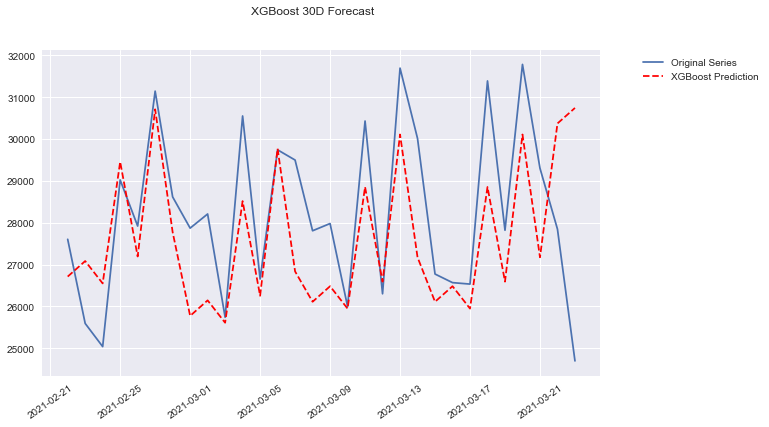

In [37]:
# plot the forecast
fig, ax = plt.subplots(1,1, figsize=(10,6))
fig.suptitle("XGBoost {}D Forecast".format(len(daily_postb_test)))
plt.plot(test_df_x.index, test_df_x.sales.values, label='Original Series')
plt.plot(test_df_x.index, yhat, color='red', label='XGBoost Prediction', linestyle="--")
plt.xticks(rotation='35')[::2]
plt.legend(bbox_to_anchor=(1.30, 1), loc='upper right')
plt.show();

In [60]:
evaulate_model_forecast(yhat, test_df_x.sales.values)

Root Mean Squared Error (RMSE): 1864.0 
 -------------------------------------------------- 

Mean Absolute Percentage Error (MAPE): 5.1% 
 -------------------------------------------------- 

Mean Absolute Erorr (MAE): 1425.0 
 -------------------------------------------------- 

R2 Score: -0.28779032006033356 
 -------------------------------------------------- 



In [ ]:
_ = plot_importance(xgboost_model, height=0.9)

In [70]:
# update model predictions params to dict:

In [ ]:
###### DUMMY 

In [116]:
# try fitting optimal params
xgboost_model = xgb.XGBRegressor(objective = 'reg:squarederror',
                                n_estimators=1000,
                                learning_rate=0.05,
                                min_child_weight=6,
                                gamma=0,
                                reg_lambda=1,
                                reg_alpha=0,
                                min_split_loss=1,
                                max_depth=3,
                                subsample=0.6,
                                colsample_bytree=0.6)

xgboost_model.fit(X_train, y_train, verbose=True)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=6, min_split_loss=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.6, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [117]:
# create the prediction series from the model, now predicted on the test set
yhat = xgboost_model.predict(X_test)

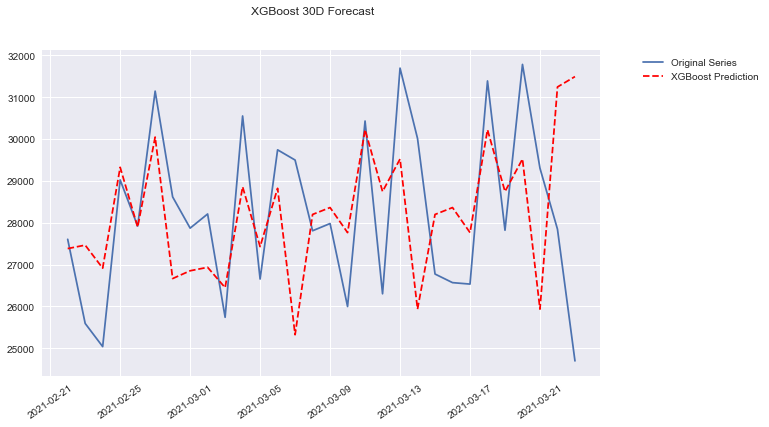

In [118]:
# plot the forecast
fig, ax = plt.subplots(1,1, figsize=(10,6))
fig.suptitle("XGBoost {}D Forecast".format(len(daily_postb_test)))
plt.plot(test_df_x.index, test_df_x.sales.values, label='Original Series')
plt.plot(test_df_x.index, yhat, color='red', label='XGBoost Prediction', linestyle="--")
plt.xticks(rotation='35')[::2]
plt.legend(bbox_to_anchor=(1.30, 1), loc='upper right')
plt.show();

In [119]:
evaulate_model_forecast(yhat, test_df_x.sales.values)

Root Mean Squared Error (RMSE): 2244.0 
 -------------------------------------------------- 

Mean Absolute Percentage Error (MAPE): 6.12% 
 -------------------------------------------------- 

Mean Absolute Erorr (MAE): 1724.0 
 -------------------------------------------------- 



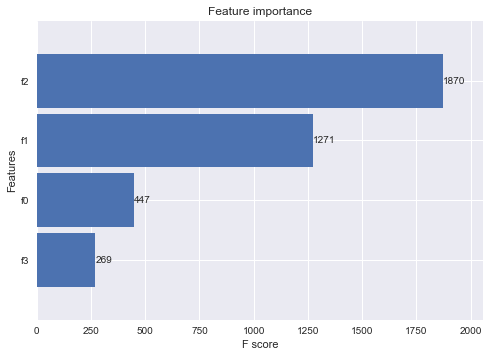

In [120]:
_ = plot_importance(xgboost_model, height=0.9)

In [121]:
# initiate a shap explainer instance from the above defined exgoobst model
shap_values_2 = shap.TreeExplainer(xgboost_model).shap_values(X_train_df)

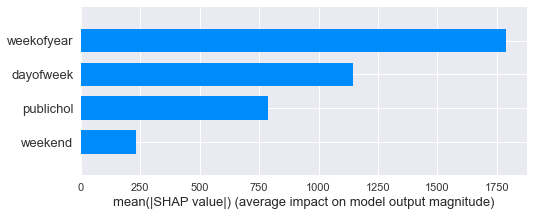

In [122]:
# plot the breakdown of each variables effect; using the explainer instance + training DF
shap.summary_plot(shap_values_2, X_train_df, plot_type='bar')

## COMMENTS
* Model performs reasonably well, although it tends to systemtically under-predict (albeit, only slightly) most of the spikes; which are generally occuring around weekends


* Unsurprisingly, the model doesn't capture the final drop of the test set, this might be some form of exogenous shock and it is not feasible to assume the training data set is rich enough to account for these surprise exogenous shocks. 


* Even with the final low data point that isn't captured at all by the model, it still achieves a 5% MAPE for a static 30D forecast, which is quite satisfactory considering the volatile retail climate of March 2021
    * Additionally, it is not explicility part of the model or econometrically-speaking a good practice, but there is a  business practice preference to prefer to slightly under-estimate sales forcasts rather than over-estimate. Thus, the more conservative side of forecasting (under-fitting) is actually not as problematic in this environment as it might be in other timeseries situations

<a id='xgboost_shap'></a>

# XGBOOST - SHAP EXPLAINER 

### BRIEF SUMMARY OF THE TABLES BELOW: 
* The 1st Summary Plot shows that "weekofyear" tends to - on average- exhibit the greatest mean impact on the model output; this is likely reflective of the upwards trend noted by the graphs at the start of this notebook. As each subsequent week progresses, the significance of the growing week number is indicative of the upwards growth trend visible in the 'sales' series.



* The 2nd summary plot tells a more detailed story
    * The 'weekofyear' has the highest degree of clustering above (0) (that is a positive impact on 'sales') which reflects the aforementioned upwards trend over time in the data. This adds strength to the above hypothesis, as on average, more weeks are on average above 0 then below, and the feature value of these above 0 observations is high.
    * The 'dayofweek' is somewhat in-line with what we expect, there are two disinct (high feature value) positive observations which most likely reflect weekends; the two purple and red dots slightly below 0 is somewhat guess work but potentially reflects the late week (Thursday - Friday) phenomena. 
        * Additionally, the purple dot at the bottom of the spectrum, is likely the significant observation that Mondays are consistently the weakest day of sales week-after-week


* The 'publichol' variable is interesting, in the first table, it is observed that the variabel has an average positive impact, although when a day is not a public-holiday, the model reads this as having a slightly negative impact on sales; however, the net impact of the variable is positive because of the high feature-value red dot which represents when public holidays do arise: the sales of these days are often extreme and push the variable mean into positive territory.
    * important to note that this is trained on the "X_train_df' as not public holidays actuall fall in the "test_df" for this particular 30D train/test split 

In [109]:
# import shap package 
import shap

In [46]:
# initiate a shap explainer instance from the above defined exgoobst model
shap_values_2 = shap.TreeExplainer(xgboost_model).shap_values(X_train_df)

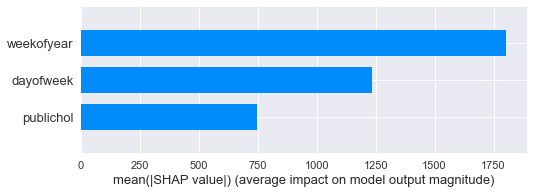

In [47]:
# plot the breakdown of each variables effect; using the explainer instance + training DF
shap.summary_plot(shap_values_2, X_train_df, plot_type='bar')

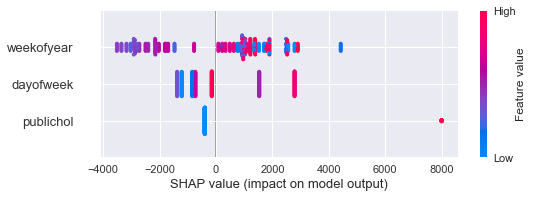

In [54]:
# breakdown futher with positive and negative relationships of each predictor with the target variable
# also gives an insight into the feature value (strength of relationship) with the colour grade
plt.figure()
shap.summary_plot(shap_values_2, X_train_df)

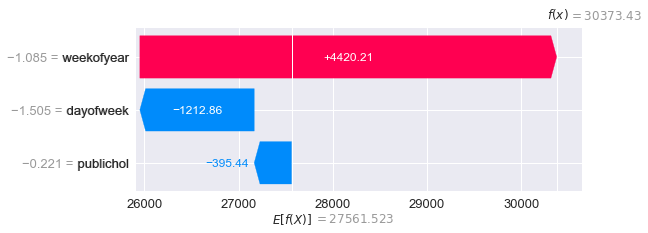

In [58]:
# for any given day of the model too, we can visualise that individual days predictors contribution
# thus, we  can see that the 'dayofweek' is likely mid-week and it is definitely not a public holiday
explainer = shap.Explainer(xgboost_model)
shap_values_3 = explainer(X_train_df)
shap.plots.waterfall(shap_values_3[2])

## 
* https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost
    * good source for plotting the worst points of the forecast 